In [253]:
import os.path
from typing import List
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from datetime import date
# from thefuzz import fuzz

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_colwidth = 160

from utils.configuration import settings
from utils.utils import *
from tft.api import *

In [254]:
RANDOM_STATE = 42

API_KEY: str = settings.api_key
ASSETS_DIR: str = settings.assets_dir
SERVER = 'na1'  # euw1 na1 kr oc1
LEAGUE='challengers' # challengers grandmasters
MAX_COUNT: int = settings.max_count
LATEST_RELEASE = '12.13.453.3037' # '12.12.450.4196''12.13.453.3037' Version 12.12.448.6653 12.11.446.9344 Version 12.13.453.3037 (Jul 11 2022/18:39:20) [PUBLIC] <Releases/12.13>
PATCH: date = date(2022, 7, 16)  # date(2022, 7, 1) date(2022, 7, 16)
THREEDAY: datetime = (datetime.now() - timedelta(days=3)).strftime("%Y-%m-%d")

TARGETNAME = 'placement'

# Data Loading

In [255]:
# raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_matches.pickle'))
raw_df: DataFrame = pd.read_pickle(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{THREEDAY}_matches.pickle'))

# Preprocessing

In [256]:
def impute(df) -> DataFrame:
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("object"):
        df[name] = df[name].fillna("None")
    return df

raw_df = impute(raw_df)

In [257]:
match_id_df: Series = raw_df['match_id']
X: DataFrame = raw_df.drop(['match_id'], axis=1)
y: Series = X.pop(TARGETNAME)
X.fillna('', inplace=True)
numeric_cols: List = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
# traits level columns
traits_col: list = [s for s in numeric_cols if "Set7" in s]
# units level columns
units_col: list = [s for s in numeric_cols if "TFT7" in s]
# augments columns
augments_col: list[str] = ['augment0', 'augment1', 'augment2']
# units items columns
items_col = [s for s in categorical_cols if s not in augments_col]
df_unique = X.nunique().to_frame().reset_index()
df_unique.columns = ['Variable','DistinctCount']
unique_items_set = {y for col in items_col for y in X[col].unique().tolist()}
unique_augments_set = {y for col in augments_col for y in X[col].unique().tolist()}
X[f'items_count'] = X[items_col].apply(lambda row: sum(x != 'None' for x in row), axis=1)
X[f'traits_sum'] = X[traits_col].sum(axis=1)
X[f'units_sum'] = X[units_col].sum(axis=1)
X.iloc[X[f'units_sum'].idxmax()]

augment0          TFT7_Augment_MageConference
augment1            TFT7_Augment_FirstAidKit2
augment2           TFT6_Augment_ForceOfNature
Set7_Assassin                             0.0
Set7_Astral                               1.0
                             ...             
TFT7_Zoe_item1                           None
TFT7_Zoe_item2                           None
items_count                                14
traits_sum                                9.0
units_sum                                29.0
Name: 7090, Length: 270, dtype: object

In [258]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
X[numeric_cols] = X[numeric_cols].applymap(np.int64)

matches_df = X.copy()
matches_df[TARGETNAME] = y

# Augments Ranking

## Stage 2-1 augment ranking

In [259]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment0').melt('placement', value_name='augment0')
# group and aggregate mean/median
dct = {'Value_Count': ('augment0', 'count'), 'average_placement': ('placement', 'mean')}
augment0_rank_df = m.groupby('augment0', as_index=False).agg(**dct).sort_values(by='average_placement')
augment0_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_34228\207590299.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment0').melt('placement', value_name='augment0')


,augment0,Value_Count,average_placement
126,TFT7_Augment_GuildLootHR,2,1.500000
150,TFT7_Augment_Preparation2HR,2,3.000000
136,TFT7_Augment_MageConferenceHR,5,3.000000
146,TFT7_Augment_MysticTrait2,25,3.680000
157,TFT7_Augment_RevelEmblem2,171,3.701754
80,TFT7_Augment_AssassinEmblem2,125,3.816000
165,TFT7_Augment_ShapeshifterBeastsDen,176,3.818182
2,TFT6_Augment_BinaryAirdrop,8,3.875000
79,TFT7_Augment_AssassinEmblem,337,3.908012
117,TFT7_Augment_GadgetExpert,520,3.944231


In [260]:
augment0_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment0_ranking.csv'), index=False)

## Stage 3-2 augment ranking

In [261]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment1').melt('placement', value_name='augment1')
# group and aggregate mean/median
dct = {'Value_Count': ('augment1', 'count'), 'average_placement': ('placement', 'mean')}
augment1_rank_df = m.groupby('augment1', as_index=False).agg(**dct).sort_values(by='average_placement')
augment1_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_34228\1890264867.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment1').melt('placement', value_name='augment1')


,augment1,Value_Count,average_placement
65,TFT6_Augment_Traitless1,26,2.384615
156,TFT7_Augment_RevelEmblem2,30,3.166667
70,TFT6_Augment_TriForce3,25,3.240000
161,TFT7_Augment_ScalescornEmblem2,35,3.285714
175,TFT7_Augment_TempestEmblem2,3,3.333333
89,TFT7_Augment_BigFriend2,26,3.538462
67,TFT6_Augment_Traitless3,11,3.545455
78,TFT7_Augment_AssassinEmblem2,18,3.555556
144,TFT7_Augment_MysticTrait2,9,3.555556
77,TFT7_Augment_AssassinEmblem,32,3.625000


In [262]:
augment1_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment1_ranking.csv'), index=False)

## Stage 4-2 augment ranking

In [263]:
# filter and melt the dataframe
m = matches_df.filter(regex=r'placement|augment2').melt('placement', value_name='augment2')
# group and aggregate mean/median
dct = {'Value_Count': ('augment2', 'count'), 'average_placement': ('placement', 'mean')}
augment2_rank_df = m.groupby('augment2', as_index=False).agg(**dct).sort_values(by='average_placement')
augment2_rank_df[:30]

C:\Users\furyx\AppData\Local\Temp\ipykernel_34228\3922423790.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  m = matches_df.filter(regex=r'placement|augment2').melt('placement', value_name='augment2')


,augment2,Value_Count,average_placement
59,TFT6_Augment_Traitless3,4,1.250000
57,TFT6_Augment_Traitless1,1,2.000000
58,TFT6_Augment_Traitless2,19,2.000000
26,TFT6_Augment_Featherweights3,2,3.000000
61,TFT6_Augment_TriForce2,8,3.375000
154,TFT7_Augment_TempestEmblem,12,3.500000
69,TFT7_Augment_AssassinTrait,18,3.555556
127,TFT7_Augment_MysticTrait,32,3.625000
52,TFT6_Augment_TheGoldenEgg,162,3.648148
145,TFT7_Augment_ShapeshifterTrait2,26,3.730769


In [264]:
augment2_rank_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_augment2_ranking.csv'), index=False)

# Items Ranking

In [265]:
def get_unit_items_ranking(df: matches_df, unit: str):
    # filter and melt the dataframe
    df = df.filter(regex=f'placement|{unit}_item0|{unit}_item1|{unit}_item2')
    df[f'unit'] = f'{unit}' # fill in current unit
    # join 3 items to 1 column
    df[f'{unit}_items'] = df[[f'{unit}_item0', f'{unit}_item1', f'{unit}_item2']].apply(lambda row: ', '.join(row.values.astype(str)), axis=1)
    # sort items for unique combination
    df[f'{unit}_items'] = df[f'{unit}_items'].apply(lambda x: ', '.join(sorted(x.split(', '))))
    df = df.filter(regex=f'placement|{unit}_items|unit')
    m = df.melt(
        ['placement',f'unit'], value_name=f'{unit}_items_grp') #, value_vars=[f'{unit}_items', f'{unit}']
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'{unit}_items_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'unit', f'{unit}_items_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [266]:
get_unit_items_ranking(df = matches_df[:2], unit='TFT7_Zoe')

,unit,TFT7_Zoe_items_grp,value_count,average_placement
0,TFT7_Zoe,"None, None, None",2,3.5


In [267]:
# Get top5 value_count >= 12
top5_items_list = []
for unit in units_col:
    df = get_unit_items_ranking(df = matches_df, unit=unit)
    df = df[df['value_count']>=12][:5] #Top 5 with counts >= 12
    top5_items_list.extend(df.values)

In [268]:
top5_items_list = pd.DataFrame(top5_items_list, columns=['unit', 'items',	'value_count',	'average_placement'])

In [269]:
top5_items_list.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_top5_items.csv'), index=False)

## Top 1 items

In [270]:
top5_items_list.groupby('unit').head(1)

,unit,items,value_count,average_placement
0,TFT7_Aatrox,"None, None, None",25976,4.490761
2,TFT7_Anivia,"ArchangelsStaff, Morellonomicon, SpearOfShojin",16,3.937500
7,TFT7_AoShin,"JeweledGauntlet, SpearOfShojin, UnstableConcoction",20,2.500000
12,TFT7_Ashe,"LastWhisper, None, None",12,3.833333
17,TFT7_AurelionSol,"HextechGunblade, MageEmblemItem, SpearOfShojin",20,4.100000
22,TFT7_Bard,"IonicSpark, None, None",12,2.083333
27,TFT7_Braum,"IonicSpark, None, None",26,3.846154
32,TFT7_Corki,"MadredsBloodrazor, RunaansHurricane, UnstableConcoction",21,3.380952
37,TFT7_Diana,"FrozenHeart, RedBuff, StatikkShiv",13,2.230769
42,TFT7_DragonBlue,"Quicksilver, RevelEmblemItem, StatikkShiv",32,3.093750


# Load TFT asset

In [271]:
tft_assets = read_json(os.path.join(ASSETS_DIR, f'en_us.json'))

In [272]:
tft7_set = tft_assets['setData'][6]['champions'] #['apiName'] ['traits']['name'] #['champions'] #['champions'].name

In [273]:
champions_dict = {}

for champion in tft7_set:
    if champion["apiName"] not in champions_dict:
        champions_dict[champion["apiName"]] = []
    for trait in champion["traits"]:
        champions_dict[champion["apiName"]].append(trait)

In [274]:
champions_dict['TFT7_Olaf']

['Scalescorn', 'Bruiser', 'Warrior']

# Team Composition Ranking

In [275]:
def add_traits(units_str):
    # for units in units_str.split(', '):
    comp_array = []
    if len(units_str) == 0:
        return ''
    for unit in units_str.split(', '):
        traits_array = []
        for trait in champions_dict[unit]:
            traits_array.append(trait[:2]+trait[-1:]) # Add first 2 char for trait
        traits_str = '-'.join(traits_array) + f'-{unit}'
        comp_array.append(traits_str)

    # print(f'{"".join(comp_array)}')
    return ','.join(comp_array)

def get_unit_comp_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(row[row > 0].index.values.astype(str)), axis=1)
    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_','') # remove prefix .split('_',1).str[-1]
    df = df.filter(['placement', 'comp'])
    m = df.melt(
        ['placement'], value_name=f'comp_grp')
    # group and aggregate mean/median average_placement
    dct = {'value_count': (f'comp_grp', 'count'),
           'average_placement': ('placement', 'mean')}
    return m.groupby([f'comp_grp'], as_index=False).agg(**dct).sort_values(by='average_placement')

In [276]:
# Get top5 
comp_df = get_unit_comp_ranking(df = matches_df)

In [277]:
top5_comp_list = []
m = comp_df[comp_df['value_count']>=1] #[:5] #Top 5 with counts >= 12
top5_comp_list.extend(m.values)
comp_ranking_df = pd.DataFrame(top5_comp_list, columns=['comp', 'value_count', 'average_placement'])

In [278]:
comp_ranking_df #.groupby('comp').head(1)

,comp,value_count,average_placement
0,"Tet-Drn-AoShin,Gud-Myc-Bad-Bard,Rel-Car-Corki,Trr-Myc-Evr-Lulu,Tet-Brr-Led-Ornn,Rel-Evr-Sona,Whs-Mae-Brr-Sylas,-TrainerDragon,Trr-Car-Tristana",2,1.0
1,"Gud-Myc-Bad-Bard,Scn-Asn-Diana,Scn-Car-Mae-Lillia,Scn-Brr-War-Olaf,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Asn-Talon,She-Spf-Mae-Zoe",1,1.0
2,"Scn-Gun-Braum,Scn-Asn-Diana,Scn-Car-Mae-Lillia,Scn-Brr-War-Olaf,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Whs-Mae-Brr-Sylas,Gud-Asn-Talon,She-Spf-Mae-Zoe",1,1.0
3,"Gud-Myc-Bad-Bard,Scn-Asn-Diana,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Asn-Talon,Gud-Swt-Twitch",1,1.0
4,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Gud-Car-Sejuani,Gud-Swt-Twitch,Mie-Drr-War-Yasuo,Mie-War-Yone",1,1.0
...,...,...,...
12446,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Jae-Shr-Neeko,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Whs-Mae-Brr-Sylas",1,8.0
12447,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Car-Nunu,Gud-Car-Sejuani,Gud-Asn-Talon,Gud-Swt-Twitch,Mie-War-Yone",1,8.0
12448,"Gud-Myc-Bad-Bard,Scn-Asn-Diana,Scn-Brr-War-Olaf,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Gud-Asn-Talon",1,8.0
12449,"Scn-Asn-Diana,Whs-Brr-Drn-DragonPurple,Whs-Shr-Elise,Whs-Asn-Pyke,Gud-Asn-Talon,Whs-Gun-Thresh",1,8.0


In [279]:
composition_ranking_df = comp_ranking_df.copy()

# Team composition Clustering

In [280]:
# from sentence_transformers import SentenceTransformer

# embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [281]:
# corpus_sentences = list(comp_ranking_df['comp'])

# corpus_embeddings = embedder.encode(corpus_sentences, batch_size=512, show_progress_bar=True, convert_to_tensor=True)
# Normalize the embeddings to unit length
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [282]:
# clustering_model = DBSCAN(eps=0.023, min_samples=1, metric='cosine', n_jobs=-1)
# predict=clustering_model.fit_predict(corpus_embeddings)
# comp_ranking_df['group'] = pd.Series(predict, index=comp_ranking_df.index)

In [283]:
# comp_ranking_df.sort_values(by='group')

In [284]:
# comp_ranking_df['grp_count'] = comp_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
# comp_ranking_df['grp_placement'] = comp_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [285]:
# comp_ranking_df.sort_values(by='group')[:60]

In [286]:
# top5_comp_ranking_list = []
# m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
# top5_comp_ranking_list.extend(m.values)
# top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [287]:
def remove_traits(units_str):
    """Remove units traits from text seperated by comma

    Args:
        units_str (str): traits-unit,traits-unit

    Returns:
        str: Units stripped of traits
    """    
    if len(units_str) == 0:
        return ''

    units_array = []
    for unit in units_str.split(','):
        units_array.append(unit.split('-')[-1])
    units = ', '.join(units_array)
    return units

# top_comp_ranking_df['comp'] = top_comp_ranking_df['comp'].apply(remove_traits)


In [288]:
# top_comp_ranking_df['mode'] = top_comp_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
# top_comp_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

In [289]:
# comp_ranking_df['comp'] = comp_ranking_df['comp'].apply(remove_traits)
# comp_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_comp_ranking.csv'), index=False)

In [290]:
# from statistics import mode
# import jellyfish

# import pandas as pd

# df = pd.DataFrame({'Code': ['abc', 'abc', 'abc', 'abcc', 'abcc', 'zxc'],
#                    'Description': ['ABC String', 'abc string', 'ABC String and sth', 'abc sth else', 'zxc sth else', 'zxc zxc'],
#                 #    'Value': [10, 20, 30, 40, 100]
#                    })

# df_list = []
# for grp,df in df.groupby('Code'):
#     df['distance'] = df['Description'].apply(lambda x : fuzz.token_set_ratio(x, mode(df['Description'])))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [291]:
# comp_ranking_df.groupby('comp')['comp'].apply(lambda x : fuzz.token_set_ratio(x, ','.join(units_col)))

In [292]:
# df_list = []
# for grp,df in comp_ranking_df.groupby('comp'):
#     df['distance'] = df['comp'].apply(lambda x : fuzz.token_set_ratio(x, 'Aatrox, DragonGold, Kayn, Shen, Twitch, Xayah, Zoe'))
#     # df['Description'] =  mode(df['Description'])
#     df_list.append(df[df['distance'] > 10])

# df = pd.concat(df_list)

In [293]:
composition_ranking_df

,comp,value_count,average_placement
0,"Tet-Drn-AoShin,Gud-Myc-Bad-Bard,Rel-Car-Corki,Trr-Myc-Evr-Lulu,Tet-Brr-Led-Ornn,Rel-Evr-Sona,Whs-Mae-Brr-Sylas,-TrainerDragon,Trr-Car-Tristana",2,1.0
1,"Gud-Myc-Bad-Bard,Scn-Asn-Diana,Scn-Car-Mae-Lillia,Scn-Brr-War-Olaf,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Asn-Talon,She-Spf-Mae-Zoe",1,1.0
2,"Scn-Gun-Braum,Scn-Asn-Diana,Scn-Car-Mae-Lillia,Scn-Brr-War-Olaf,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Whs-Mae-Brr-Sylas,Gud-Asn-Talon,She-Spf-Mae-Zoe",1,1.0
3,"Gud-Myc-Bad-Bard,Scn-Asn-Diana,Whs-Brr-Drn-DragonPurple,Tet-Brr-Led-Ornn,Whs-Asn-Pyke,Tet-Asn-Qiyana,Gud-Asn-Talon,Gud-Swt-Twitch",1,1.0
4,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Scn-Car-Mae-Lillia,Mie-Car-Nunu,Gud-Car-Sejuani,Gud-Swt-Twitch,Mie-Drr-War-Yasuo,Mie-War-Yone",1,1.0
...,...,...,...
12446,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Jae-Shr-Neeko,Mie-Car-Nunu,Tet-Brr-Led-Ornn,Whs-Mae-Brr-Sylas",1,8.0
12447,"Mie-Drn-DragonBlue,Rag-Car-Hecarim,Mie-Car-Nunu,Gud-Car-Sejuani,Gud-Asn-Talon,Gud-Swt-Twitch,Mie-War-Yone",1,8.0
12448,"Gud-Myc-Bad-Bard,Scn-Asn-Diana,Scn-Brr-War-Olaf,Tet-Brr-Led-Ornn,Tet-Asn-Qiyana,Rag-Brr-War-Shen,Gud-Asn-Talon",1,8.0
12449,"Scn-Asn-Diana,Whs-Brr-Drn-DragonPurple,Whs-Shr-Elise,Whs-Asn-Pyke,Gud-Asn-Talon,Whs-Gun-Thresh",1,8.0


# KMode
using - comp string

In [294]:
# # Elbow curve to find optimal K
# cost = []
# K = range(5,30,5)
# for num_clusters in list(K):
#     kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
#     kmode.fit_predict(composition_ranking_df)
#     cost.append(kmode.cost_)
    
# plt.plot(K, cost, 'bx-')
# plt.xlabel('No. of clusters')
# plt.ylabel('Cost')
# plt.title('Elbow Method For Optimal k')
# plt.show()

In [295]:
# # Building the model with 3 clusters
# kmode = KModes(n_clusters=15, init = "random", n_init = 5, verbose=1)
# clusters = kmode.fit_predict(composition_ranking_df)
# clusters

In [296]:
# kmode_ranking_df = composition_ranking_df.copy()
# kmode_ranking_df.insert(0, "group", clusters, True)

In [297]:
# kmode_ranking_df

In [298]:
# kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['value_count'].transform('sum')
# kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['average_placement'].transform('mean')

In [299]:
# top5_comp_ranking_list = []
# m = comp_ranking_df[comp_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
# top5_comp_ranking_list.extend(m.values)
# top_comp_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['comp', 'value_count', 'average_placement', 'group', 'grp_count', 'grp_placement'])

In [300]:
# kmode_ranking_df['comp'] = kmode_ranking_df['comp'].apply(remove_traits)
# kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
# kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

# _

In [301]:
def get_unit_composition(df: matches_df):
    # filter and melt the dataframe
    df = df.filter(['placement']+units_col+traits_col)
    return df.sort_values(by='placement')

In [302]:
units_comp_df:DataFrame = get_unit_composition(matches_df)

In [303]:
units_comp_df

,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,TFT7_Diana,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
11644,1,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,1,0,0,2
3022,1,0,0,0,0,0,0,0,0,3,...,1,0,0,0,0,0,1,0,1,0
16475,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3025,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
22411,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21962,8,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3384,8,0,0,0,0,0,0,2,0,2,...,2,0,0,0,0,0,1,0,1,0
15088,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
15132,8,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


## KMode
using integers

In [304]:
units_composition_df = units_comp_df.copy()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 8222, cost: 305367.0
Run 1, iteration: 2/100, moves: 2099, cost: 304638.0
Run 1, iteration: 3/100, moves: 302, cost: 304638.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7451, cost: 308179.0
Run 2, iteration: 2/100, moves: 2033, cost: 306997.0
Run 2, iteration: 3/100, moves: 1085, cost: 305654.0
Run 2, iteration: 4/100, moves: 778, cost: 305654.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 11358, cost: 328196.0
Run 3, iteration: 2/100, moves: 2571, cost: 322249.0
Run 3, iteration: 3/100, moves: 929, cost: 321408.0
Run 3, iteration: 4/100, moves: 99, cost: 321408.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 10225, cost: 301558.0
Run 4, iteration: 2/100, moves: 1766, cost: 301

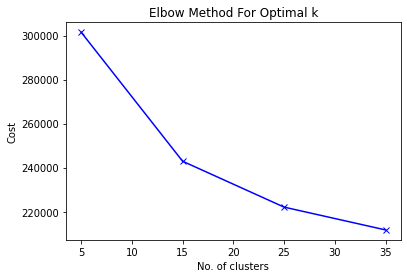

In [305]:
# Elbow curve to find optimal K
cost = []
K = range(5,40,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(units_composition_df)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [306]:
# Building the model with 3 clusters
kmode = KModes(n_clusters=25, init = "random", n_init = 5, verbose=1)
clusters = kmode.fit_predict(units_composition_df)
clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10584, cost: 231714.0
Run 1, iteration: 2/100, moves: 2262, cost: 230722.0
Run 1, iteration: 3/100, moves: 1058, cost: 229971.0
Run 1, iteration: 4/100, moves: 269, cost: 229971.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 9078, cost: 235305.0
Run 2, iteration: 2/100, moves: 2572, cost: 233380.0
Run 2, iteration: 3/100, moves: 1316, cost: 231786.0
Run 2, iteration: 4/100, moves: 361, cost: 231710.0
Run 2, iteration: 5/100, moves: 0, cost: 231710.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 8670, cost: 225952.0
Run 3, iteration: 2/100, moves: 3364, cost: 224887.0
Run 3, iteration: 3/100, moves: 922, cost: 224501.0
Run 3, iteration: 4/100, moves: 149, cost: 224087.0
Run 3, iteration: 5/100, moves: 647, cost: 224087.0
Init: initializing centro

array([11, 16, 15, ..., 19, 17,  5], dtype=uint16)

In [307]:
kmode_ranking_df = units_composition_df.copy()
kmode_ranking_df.insert(0, "group", clusters, True)

In [308]:
kmode_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
11644,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
3022,16,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
16475,15,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3025,10,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
22411,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21962,8,8,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3384,12,8,0,0,0,0,0,0,2,0,...,2,0,0,0,0,0,1,0,1,0
15088,19,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
15132,17,8,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


In [309]:
def get_unit_composition_ranking(df: DataFrame, add_trait=True):
    # filter and melt the dataframe
    df = df.filter(['placement', 'group']+units_col)
    # join units lvl > 0 to 1 column
    df['comp'] = df[units_col].apply(lambda row: ', '.join(
        row[row > 0].index.values.astype(str)), axis=1)

    if add_trait:
        df['comp'] = df['comp'].apply(add_traits)

    df['comp'] = df['comp'].str.replace('TFT7_', '')
    df = df.filter(['placement', 'group', 'comp'])
    return df.sort_values(by='group')

In [310]:
kmode_ranking_df = get_unit_composition_ranking(kmode_ranking_df, add_trait=False)

In [311]:
kmode_ranking_df

,placement,group,comp
739,3,0,"DragonPurple, Elise, Neeko, Ryze, Sylas, Thresh, Zoe"
16966,3,0,"DragonPurple, Elise, Neeko, Soraka, Sylas, Taric, Thresh"
24985,7,0,"DragonPurple, Elise, Illaoi, Ornn, Shen, Sylas, Thresh"
23941,7,0,"DragonPurple, Elise, Gnar, Swain, Sylas, Thresh"
14585,2,0,"Bard, Diana, DragonPurple, Elise, Pyke, Sylas, Talon, Thresh"
...,...,...,...
21808,7,24,"Anivia, Ashe, Karma, LeeSin, Ornn, Sett, Volibear"
17810,3,24,"Ashe, Karma, LeeSin, Neeko, Shyvana, Swain, Yasuo"
2396,4,24,"Ashe, Bard, Elise, Karma, Neeko, Pyke, Shyvana, Swain"
10196,7,24,"Ashe, Karma, LeeSin, Neeko, Sett, Swain, Volibear, Xayah"


In [312]:
kmode_ranking_df['grp_count'] = kmode_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmode_ranking_df['grp_placement'] = kmode_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [313]:
kmode_ranking_df

,placement,group,comp,grp_count,grp_placement
739,3,0,"DragonPurple, Elise, Neeko, Ryze, Sylas, Thresh, Zoe",1544,4.46956
16966,3,0,"DragonPurple, Elise, Neeko, Soraka, Sylas, Taric, Thresh",1544,4.46956
24985,7,0,"DragonPurple, Elise, Illaoi, Ornn, Shen, Sylas, Thresh",1544,4.46956
23941,7,0,"DragonPurple, Elise, Gnar, Swain, Sylas, Thresh",1544,4.46956
14585,2,0,"Bard, Diana, DragonPurple, Elise, Pyke, Sylas, Talon, Thresh",1544,4.46956
...,...,...,...,...,...
21808,7,24,"Anivia, Ashe, Karma, LeeSin, Ornn, Sett, Volibear",476,4.87395
17810,3,24,"Ashe, Karma, LeeSin, Neeko, Shyvana, Swain, Yasuo",476,4.87395
2396,4,24,"Ashe, Bard, Elise, Karma, Neeko, Pyke, Shyvana, Swain",476,4.87395
10196,7,24,"Ashe, Karma, LeeSin, Neeko, Sett, Swain, Volibear, Xayah",476,4.87395


In [314]:
top5_comp_ranking_list = []
m = kmode_ranking_df[kmode_ranking_df['grp_count']>=10] #[:5] #Top 5 with counts >= 12
top5_comp_ranking_list.extend(m.values)
top_kmode_ranking_df = pd.DataFrame(top5_comp_ranking_list, columns=['placement', 'group', 'comp', 'grp_count', 'grp_placement'])

In [315]:
kmode_ranking_df['mode'] = kmode_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmode_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
14235,6,21,"Bard, Heimerdinger, Illaoi, Lillia, Lulu, Nami, Sylas, TrainerDragon, Vladimir",240,2.291667,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Sylas, TrainerDragon, Twitch, Varus, Zoe"
2663,1,22,"Bard, DragonGold, Heimerdinger, Kayn, Lulu, Ryze, TrainerDragon, Yasuo, Zoe",1154,2.795494,"AoShin, Bard, Heimerdinger, Lulu, Ornn, Sylas, TrainerDragon, Zoe"
1592,2,4,"AoShin, Bard, DragonPurple, Lulu, Ornn, Pyke, Yasuo",927,3.393743,"AoShin, Bard, Lulu, Nami, Ornn, Sylas, Zoe"
22198,2,7,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Zoe",576,3.585069,"Bard, Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Zoe"
14081,3,16,"Diana, Olaf, Ornn, Qiyana, Shen, Sylas, Talon",929,3.715823,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
10535,3,3,"Anivia, Bard, DragonGreen, Gnar, Lulu, Neeko, Sona",972,3.944444,"Anivia, Ashe, DragonGreen, Gnar, Karma, Neeko, Soraka"
13814,8,15,"Bard, DragonBlue, Hecarim, Nunu, Sejuani, Soraka, Yasuo",803,4.075965,"DragonBlue, Hecarim, Leona, Nunu, Sejuani, Yasuo, Yone"
2413,2,18,"Bard, Corki, DragonGold, Lulu, Sona, Talon, Thresh, TrainerDragon, Tristana, Zoe",1147,4.083697,"Bard, Braum, Corki, DragonGold, Lulu, Sona, TrainerDragon, Tristana"
10349,7,17,"Elise, Gnar, Neeko, Nidalee, Shyvana, Swain",852,4.157277,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
15943,8,11,"Bard, Elise, Neeko, Ornn, Qiyana, Sylas, Talon",1226,4.216150,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"


In [316]:
kmode_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_kmode_comp_ranking.csv'), index=False)

## KMeans

In [317]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

11644    1
3022     1
16475    1
3025     1
22411    1
        ..
21962    8
3384     8
15088    8
15132    8
14908    8
Name: placement, Length: 26192, dtype: int64

In [318]:
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
kms = KMeans(n_clusters=num_clusters, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)

Initialization complete
Iteration 0, inertia 11058.699922879932.
Iteration 1, inertia 7427.623555730629.
Iteration 2, inertia 7178.005454137697.
Iteration 3, inertia 7032.555460938982.
Iteration 4, inertia 6953.208523563623.
Iteration 5, inertia 6922.37505256531.
Iteration 6, inertia 6903.714521862576.
Iteration 7, inertia 6893.945721169476.
Iteration 8, inertia 6889.998562921258.
Iteration 9, inertia 6887.860875838753.
Iteration 10, inertia 6885.953959704176.
Iteration 11, inertia 6882.815089043699.
Iteration 12, inertia 6880.526442261408.
Iteration 13, inertia 6879.523898242539.
Iteration 14, inertia 6879.0095912118295.
Iteration 15, inertia 6878.652152485782.
Iteration 16, inertia 6878.503462443182.
Iteration 17, inertia 6878.42901414728.
Iteration 18, inertia 6878.359575679195.
Iteration 19, inertia 6878.300349132553.
Iteration 20, inertia 6878.221388791491.
Iteration 21, inertia 6878.144935807449.
Iteration 22, inertia 6878.096607715168.
Iteration 23, inertia 6878.047455624097.
It

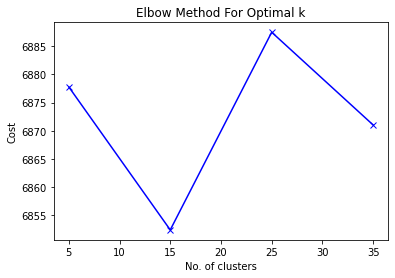

In [319]:
# Elbow curve to find optimal K
cost = []
K = range(5,40,10)
for num_clusters in list(K):
    kmeans.fit_predict(X)
    cost.append(kmeans[-1].inertia_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [320]:
# Building the model with 30 clusters
kms = KMeans(n_clusters=30, init = "k-means++", n_init = 10, verbose=1)
kmeans = make_pipeline(normalizer, kms)
clusters = kmeans.fit_predict(X)
clusters

Initialization complete
Iteration 0, inertia 11306.315885606607.
Iteration 1, inertia 7831.669979600403.
Iteration 2, inertia 7641.424435813348.
Iteration 3, inertia 7538.8248681569185.
Iteration 4, inertia 7483.173752569791.
Iteration 5, inertia 7457.767580833254.
Iteration 6, inertia 7438.295816171977.
Iteration 7, inertia 7428.548407337266.
Iteration 8, inertia 7419.77835542632.
Iteration 9, inertia 7409.606523786359.
Iteration 10, inertia 7389.854225703856.
Iteration 11, inertia 7364.5089084406.
Iteration 12, inertia 7355.475217715901.
Iteration 13, inertia 7352.167898415397.
Iteration 14, inertia 7350.349306898448.
Iteration 15, inertia 7349.689309794286.
Iteration 16, inertia 7349.3191963887575.
Iteration 17, inertia 7349.075114943871.
Iteration 18, inertia 7348.940128577626.
Iteration 19, inertia 7348.875105371402.
Iteration 20, inertia 7348.71597611771.
Iteration 21, inertia 7348.545266483059.
Iteration 22, inertia 7348.289856211297.
Iteration 23, inertia 7348.076980269921.
Ite

array([29,  6,  5, ...,  4, 11, 12])

In [321]:
kmeans_ranking_df = units_composition_df.copy()
kmeans_ranking_df.insert(0, "group", clusters, True)

In [322]:
kmeans_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
11644,29,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
3022,6,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
16475,5,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3025,26,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
22411,2,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21962,22,8,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3384,6,8,0,0,0,0,0,0,2,0,...,2,0,0,0,0,0,1,0,1,0
15088,4,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
15132,11,8,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


In [323]:
kmeans_ranking_df = get_unit_composition_ranking(kmeans_ranking_df, add_trait=False)

In [324]:
kmeans_ranking_df

,placement,group,comp
4536,8,0,"Illaoi, Lulu, Nami, Qiyana, Skarner, Twitch, Varus"
7429,1,0,"Bard, Illaoi, Skarner, Twitch, Varus, Xayah"
8318,8,0,"Illaoi, Skarner, Twitch, Varus"
14708,4,0,"DragonPurple, Illaoi, Lulu, Ornn, Shen, Twitch, Varus"
11739,2,0,"Bard, Illaoi, Ornn, Pyke, Soraka, Sylas, Talon, Twitch, Varus"
...,...,...,...
3282,4,29,"DragonPurple, Ornn, Pyke, Qiyana, Sylas, Talon, Thresh"
1812,6,29,"Diana, DragonPurple, Elise, Ornn, Qiyana, Talon"
18981,1,29,"Bard, Diana, DragonPurple, Ornn, Pyke, Qiyana, Talon, Yasuo"
22187,3,29,"Diana, DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"


In [325]:
kmeans_ranking_df['grp_count'] = kmeans_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
kmeans_ranking_df['grp_placement'] = kmeans_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')

In [326]:
kmeans_ranking_df['mode'] = kmeans_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
kmeans_ranking_df.groupby(['group']).head(1).sort_values(by='grp_placement')

,placement,group,comp,grp_count,grp_placement,mode
16236,2,1,"AoShin, Heimerdinger, Illaoi, Lulu, Nami, Ornn, Sona, TrainerDragon, Zoe",1598,3.309136,"AoShin, Bard, Heimerdinger, Lulu, Ornn, Sylas, TrainerDragon, Zoe"
13671,4,15,"AoShin, Qiyana",865,3.588439,"AoShin, Bard, Lulu, Nami, Ornn, Sylas, Zoe"
15693,2,6,"Braum, Diana, Lillia, Olaf, Ornn, Pyke, Qiyana, Talon",1233,3.957826,"Diana, Olaf, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
7730,5,16,"Bard, Diana, Illaoi, Nami, Ornn, Qiyana, Twitch, Varus",525,4.083810,"Bard, Illaoi, Nami, Ornn, Qiyana, Talon, Twitch, Varus"
5348,1,14,"DragonPurple, Heimerdinger, Lulu, Nami, Ornn, Sylas, TrainerDragon, Varus",693,4.105339,"Heimerdinger, Illaoi, Lulu, Nami, Sylas, TrainerDragon, Twitch, Varus"
2602,4,29,"DragonPurple, Neeko, Ornn, Pyke, Qiyana, Sylas, Talon",791,4.226296,"DragonPurple, Ornn, Pyke, Qiyana, Shen, Sylas, Talon"
19567,6,24,"Anivia, Braum, Corki, Hecarim, Neeko, Ornn, Pyke",320,4.228125,"Bard, Corki, Hecarim, Neeko, Ornn, Pyke, Xayah, Yasuo"
5573,7,11,"Elise, Gnar, Neeko, Nidalee, Shyvana, Swain",824,4.243932,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
237,1,2,"DragonPurple, Elise, Gnar, Neeko, Pyke, Swain, Sylas",1342,4.384501,"DragonPurple, Elise, Neeko, Soraka, Sylas, Taric, Thresh"
4210,6,10,"Anivia, DragonGreen, Gnar, Lulu, Neeko, Soraka",873,4.429553,"Anivia, Ashe, DragonGreen, Gnar, Karma, Neeko, Soraka"


In [327]:
kmeans_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_kmeans_comp_ranking.csv'), index=False)

## DBSCAN

In [328]:
units_composition_df = units_comp_df.copy()
X = units_composition_df.copy()
X.pop(TARGETNAME)

11644    1
3022     1
16475    1
3025     1
22411    1
        ..
21962    8
3384     8
15088    8
15132    8
14908    8
Name: placement, Length: 26192, dtype: int64

In [329]:
units_composition_df.shape

(26192, 88)

In [330]:
# Building the model with 3 clusters
# normalization to improve the k-means result.
normalizer = Normalizer(copy=False)
dbs= DBSCAN(eps=0.37, metric='euclidean', min_samples=3, n_jobs=-1) #eps=0.053, metric='cosine'
dbscan = make_pipeline(normalizer, dbs)
clusters = dbscan.fit_predict(X)
clusters

array([ 0,  0,  1, ...,  3,  4, -1], dtype=int64)

In [331]:
dbscan_ranking_df = units_composition_df.copy()
dbscan_ranking_df.insert(0, "group", clusters, True)

In [332]:
dbscan_ranking_df

,group,placement,TFT7_Aatrox,TFT7_Anivia,TFT7_AoShin,TFT7_Ashe,TFT7_AurelionSol,TFT7_Bard,TFT7_Braum,TFT7_Corki,...,Set7_Scalescorn,Set7_Shapeshifter,Set7_Shimmerscale,Set7_SpellThief,Set7_Starcaller,Set7_Swiftshot,Set7_Tempest,Set7_Trainer,Set7_Warrior,Set7_Whispers
11644,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
3022,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
16475,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3025,2,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
22411,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21962,2,8,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3384,0,8,0,0,0,0,0,0,2,0,...,2,0,0,0,0,0,1,0,1,0
15088,3,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
15132,4,8,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0


In [333]:
dbscan_ranking_df = get_unit_composition_ranking(dbscan_ranking_df, add_trait=False)

In [334]:
dbscan_ranking_df

,placement,group,comp
14908,8,-1,"DragonBlue, Nunu, Ornn, Qiyana, Shen, Talon, Twitch"
18546,6,-1,"Illaoi, Nami, Ryze, Senna, Shen, Sylas, Talon, Twitch"
283,6,-1,"Bard, Corki, Hecarim, Neeko, Ornn, Soraka, Talon, Xayah"
6128,6,-1,"Aatrox, Lillia, Nunu, Olaf, Shen, Talon, Yone"
803,2,-1,"AurelionSol, Heimerdinger, Lulu, Nami, Ryze, Sylas, TrainerDragon, Yasuo, Zoe"
...,...,...,...
3079,8,177,"Bard, Heimerdinger, Lillia, Lulu, Nami, Ryze, Sejuani, Sylas, TrainerDragon"
19290,8,178,"Aatrox, DragonGold, Hecarim, Kayn, Twitch, Xayah"
13239,7,178,"Aatrox, DragonGold, Hecarim, Kayn, Twitch, Xayah, Yasuo"
22710,8,178,"Aatrox, DragonGold, Hecarim, Kayn, Twitch, Xayah, Yasuo"


In [335]:
dbscan_ranking_df['grp_count'] = dbscan_ranking_df.groupby(['group'], as_index=False)['group'].transform('count')
dbscan_ranking_df['grp_placement'] = dbscan_ranking_df.groupby(['group'], as_index=False)['placement'].transform('mean')
dbscan_ranking_df['mode'] = dbscan_ranking_df.groupby('group')['comp'].transform(lambda x: pd.Series.mode(x)[0])
dbscan_ranking_df.groupby(['group']).head(1).sort_values(by='grp_count', ascending=False)[:60]

,placement,group,comp,grp_count,grp_placement,mode
15088,8,3,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah",9329.0,4.507644,"Hecarim, Ornn, Qiyana, Sejuani, Shen, Talon, Twitch, Xayah"
12880,6,0,"DragonPurple, Elise, Neeko, Ornn, Sylas, Thresh",6617.0,4.238631,"DragonPurple, Elise, Neeko, Soraka, Sylas, Taric, Thresh"
13161,5,1,"DragonBlue, Hecarim, Leona, Lillia, Nunu, Sejuani, Yone",4002.0,4.533396,"DragonBlue, Hecarim, Leona, Nunu, Sejuani, Yasuo, Yone"
8743,1,4,"Elise, Gnar, Neeko, Nidalee, Shyvana, Swain, Yasuo",2551.0,3.759219,"Elise, Gnar, Neeko, Nidalee, Shyvana, Soraka, Swain"
18538,7,2,"Braum, Corki, DragonGold, Jinx, Lulu, Sona, TrainerDragon, Tristana",1063.0,4.300461,"Heimerdinger, Illaoi, Lulu, Nami, Ryze, Sylas, TrainerDragon, Vladimir"
15057,5,5,"DragonGreen, Gnar, Lulu, Neeko, Pyke, Soraka, Talon",461.0,4.188341,"Anivia, Ashe, DragonGreen, Gnar, Karma, Neeko, Soraka"
19140,5,6,"Corki, Hecarim, Lulu, Neeko, Ornn, Pyke, Xayah, Yasuo",446.0,3.379747,"Bard, Corki, Hecarim, Neeko, Ornn, Pyke, Xayah, Yasuo"
4806,5,10,"Braum, Diana, Olaf, Ornn, Qiyana",316.0,2.750000,"Braum, Diana, Olaf, Ornn, Qiyana"
9399,8,9,"Ashe, Karma, LeeSin, Sett, Swain, Volibear",119.0,4.958861,"Ashe, Karma, LeeSin, Neeko, Sett, Shen, Swain, Yasuo"
10445,5,19,"Bard, Corki, Diana, Hecarim, Neeko, Ornn, Xayah, Yasuo",116.0,3.333333,"Bard, Corki, Diana, Hecarim, Neeko, Ornn, Xayah, Yasuo"


In [336]:
dbscan_ranking_df.to_csv(os.path.join(ASSETS_DIR, f'{SERVER}_{LEAGUE}_{LATEST_RELEASE}_{PATCH}_{THREEDAY}_dbscan_comp_ranking.csv'), index=False)